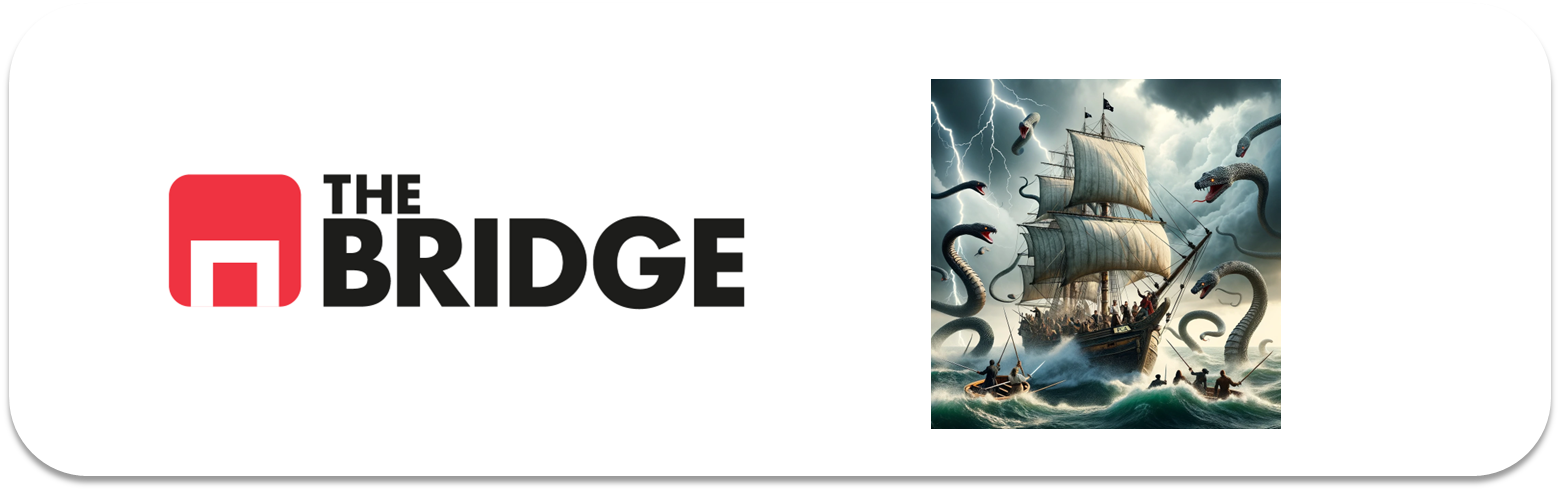

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quinientas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

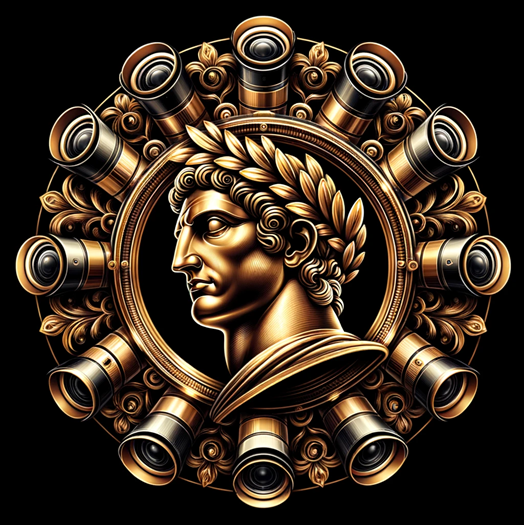

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA

from sklearn.metrics import balanced_accuracy_score

from sklearn.datasets import fetch_olivetti_faces

from toolbox_DS import *

### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




## Datos

In [28]:
face = fetch_olivetti_faces()
df = pd.DataFrame(face.data,columns=([f'Pixel{n}' for n in range(0,face.data.shape[1])]))
df.head(8)

,Pixel0,Pixel1,Pixel2,Pixel3,Pixel4,Pixel5,Pixel6,Pixel7,Pixel8,Pixel9,...,Pixel4086,Pixel4087,Pixel4088,Pixel4089,Pixel4090,Pixel4091,Pixel4092,Pixel4093,Pixel4094,Pixel4095
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.665289,0.669421,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.136364,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.074380,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.652893,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.190083,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554
5,0.549587,0.545455,0.541322,0.537190,0.537190,0.533058,0.528926,0.533058,0.590909,0.611570,...,0.623967,0.619835,0.623967,0.615702,0.661157,0.661157,0.690083,0.714876,0.706612,0.702479
6,0.330579,0.305785,0.330579,0.351240,0.425620,0.500000,0.603306,0.632231,0.644628,0.644628,...,0.516529,0.541322,0.541322,0.524793,0.537190,0.487603,0.190083,0.144628,0.152893,0.152893
7,0.128099,0.185950,0.247934,0.314050,0.388430,0.462810,0.520661,0.557851,0.590909,0.623967,...,0.289256,0.157025,0.165289,0.148760,0.157025,0.157025,0.152893,0.152893,0.173554,0.173554


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 4096 entries, Pixel0 to Pixel4095
dtypes: float32(4096)
memory usage: 6.3 MB


In [30]:
target = face.target
target.shape

(400,)

In [31]:
df['target'] = target

## Train-test-split

In [32]:
train_set,test_set = train_test_split(df, test_size=0.2,stratify=target,random_state=42) 
print('Train_set',train_set.shape)
print('Test_set', test_set.shape)

Train_set (320, 4097)
Test_set (80, 4097)


## Mini-EDA

In [33]:
train_set.describe().round(2)

,Pixel0,Pixel1,Pixel2,Pixel3,Pixel4,Pixel5,Pixel6,Pixel7,Pixel8,Pixel9,...,Pixel4087,Pixel4088,Pixel4089,Pixel4090,Pixel4091,Pixel4092,Pixel4093,Pixel4094,Pixel4095,target
count,320.00,320.00,320.00,320.00,320.00,320.00,320.00,320.00,320.00,320.00,...,320.00,320.00,320.00,320.00,320.00,320.00,320.00,320.00,320.00,320.00
mean,0.40,0.44,0.48,0.52,0.56,0.59,0.63,0.65,0.67,0.68,...,0.37,0.36,0.35,0.33,0.33,0.34,0.32,0.32,0.31,19.50
std,0.18,0.19,0.19,0.19,0.19,0.17,0.16,0.15,0.14,0.14,...,0.18,0.18,0.19,0.18,0.18,0.19,0.19,0.18,0.18,11.56
min,0.09,0.07,0.09,0.04,0.11,0.11,0.12,0.12,0.12,0.14,...,0.04,0.05,0.05,0.03,0.01,0.05,0.06,0.06,0.03,0.00
25%,0.25,0.27,0.31,0.38,0.46,0.52,0.55,0.58,0.60,0.61,...,0.22,0.21,0.20,0.18,0.18,0.17,0.17,0.18,0.17,9.75
50%,0.40,0.46,0.51,0.55,0.59,0.62,0.66,0.67,0.68,0.70,...,0.37,0.35,0.33,0.31,0.30,0.30,0.29,0.28,0.27,19.50
75%,0.53,0.57,0.63,0.67,0.70,0.71,0.74,0.76,0.77,0.78,...,0.50,0.50,0.49,0.46,0.46,0.46,0.45,0.42,0.42,29.25
max,0.81,0.82,0.87,0.86,0.86,0.86,0.87,0.87,0.87,0.87,...,0.90,0.89,0.90,0.83,0.79,0.92,0.93,0.88,0.82,39.00


No es necesario hacerlo dado que solo hay variables numéricas y son todas muy parecidas (excepto la variable target)

## Recall medio

In [34]:
X_train = train_set.drop(columns='target')
y_train = train_set['target']
X_test = test_set.drop(columns='target')
y_test = test_set['target']

In [35]:
reg_log = LogisticRegression(max_iter=1000,random_state=42)
rf = RandomForestClassifier(max_depth=5,random_state=42)
xgb = XGBClassifier(max_depth= 10, random_state = 42)
cat = CatBoostClassifier(max_depth=10, random_state = 42)

In [36]:
#model_name = ['LogosticRegression', 'RandomForestClassifier','XGBClassifier','CatBoostClassifier']
#model_inst = [reg_log,rf,xgb,cat]
#valores = []

#for modelo_in in model_inst:
    #cross_val = cross_val_score(modelo_in,X_train,y_train,cv=5,scoring="balanced_accuracy")
    #media_val = np.mean(cross_val)
    #valores.append(media_val)

#for nombre,valor in map(model_name,valores):
    #print(f'Para {nombre}:{valor:.2f}')

Ponía que tardaba 2 días y 15 horas.... 

In [37]:
media_val = []
cross_val = cross_val_score(rf,X_train,y_train,cv=5,scoring="balanced_accuracy")
media_val.append(cross_val)
print(f'RandomForest. Valor balance-accuracy:{np.mean(media_val):.3f}')
media_val


RandomForest. Valor balance-accuracy:0.683


[array([0.7375, 0.625 , 0.675 , 0.675 , 0.7   ])]

In [38]:
#cross_val = cross_val_score(xgb,X_train,y_train,cv=5,scoring="balanced_accuracy")
#media_val = np.mean(cross_val)
#print(f'XGBClassifier. Valor balance-accuracy:{media_val}')

In [39]:
#cross_val = cross_val_score(cat,X_train,y_train,cv=5,scoring="balanced_accuracy")
#media_val = np.mean(cross_val)
#print(f'CatBoostClassifier. Valor balance-accuracy:{media_val}')

In [40]:
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [41]:
y_predict = rf.predict(X_train)
print(classification_report(y_train,y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       0.39      0.88      0.54         8
           3       1.00      0.38      0.55         8
           4       0.50      0.25      0.33         8
           5       1.00      1.00      1.00         8
           6       0.89      1.00      0.94         8
           7       1.00      1.00      1.00         8
           8       0.80      1.00      0.89         8
           9       0.89      1.00      0.94         8
          10       1.00      1.00      1.00         8
          11       0.89      1.00      0.94         8
          12       1.00      0.38      0.55         8
          13       0.89      1.00      0.94         8
          14       1.00      0.38      0.55         8
          15       1.00      1.00      1.00         8
          16       1.00      0.88      0.93         8
          17       0.67    

In [42]:
balanced_acc = balanced_accuracy_score(y_train, y_predict)
print(f'Balanced Accuracy: {balanced_acc:.2f}')

Balanced Accuracy: 0.89


In [43]:
# Mejora de hiperparámetros y commparación contra train

param_rf = {
    'n_estimators':[100,200,300],
    'max_depth':[2,4,6],
    'min_samples_split':[4,6],
    'class_weight':['balanced'],
    'verbose':[0],
   }

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=param_rf,
    scoring='balanced_accuracy',
    n_jobs=-1,
)

rf_grid.fit(X_train,y_train)

y_predict_rf_grid= rf_grid.predict(X_train)
print(classification_report(y_train,y_predict_rf_grid))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       0.89      1.00      0.94         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         8
          12       1.00      0.75      0.86         8
          13       0.89      1.00      0.94         8
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00         8
          16       1.00      1.00      1.00         8
          17       1.00    

In [44]:
balanced_acc = balanced_accuracy_score(y_train, y_predict_rf_grid)
print(f'Balanced Accuracy: {balanced_acc:.2f}')

Balanced Accuracy: 0.99


In [45]:
rf_grid.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=4, n_estimators=300, random_state=42)

In [46]:
# Comparación contra test
y_predict_rf_grid_test= rf_grid.predict(X_test)
print(classification_report(y_test,y_predict_rf_grid_test))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       1.00      1.00      1.00         2
           2       0.67      1.00      0.80         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       1.00      1.00      1.00         2
           6       0.40      1.00      0.57         2
           7       0.67      1.00      0.80         2
           8       0.50      0.50      0.50         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       0.00      0.00      0.00         2
          13       1.00      1.00      1.00         2
          14       1.00      0.50      0.67         2
          15       1.00      0.50      0.67         2
          16       0.00      0.00      0.00         2
          17       0.50    

c:\Users\Alfonso\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alfonso\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alfonso\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [47]:
balanced_acc = balanced_accuracy_score(y_test, y_predict_rf_grid_test)
print(f'Balanced Accuracy: {balanced_acc:.2f}')

Balanced Accuracy: 0.78


BALANCE_ACCURACY sin PCA:  
- RF con cross_validation: 0.68. En classification_report: 0.89
- RF afinando hiperparámetros y entrenado contra train, en classification_report: 0.99
- RF afinando hiperparámetros y entrenado contra test, en classification_report: 0.78

### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

#### 1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).

In [48]:
pca_cl = PCA()

pca_cl.fit(X_train)

X_train_pca = pca_cl.transform(X_train)
X_test_pca = pca_cl.transform(X_test)

In [49]:
X_train_pca

array([[-5.6978881e-02,  1.7112639e+00,  2.7042069e+00, ...,
         1.5403939e-02,  1.0809567e-02,  8.9816749e-06],
       [-9.9309273e+00, -5.0016494e+00, -1.4829540e+00, ...,
        -2.0611867e-02,  9.2764162e-03,  8.7134540e-06],
       [-2.8180645e+00,  3.1814916e+00,  1.0919523e+00, ...,
        -1.6491368e-02,  1.6725108e-02,  8.8633969e-06],
       ...,
       [ 1.0048679e+01, -1.5325148e-01, -3.1924963e-02, ...,
        -1.1178574e-02, -3.2677539e-03,  9.4175339e-06],
       [-2.6487739e+00,  1.0503252e+00,  2.9578280e+00, ...,
        -1.4113322e-02,  1.8918404e-02,  9.2331320e-06],
       [-5.1369753e+00,  1.2605500e+00, -1.9049635e+00, ...,
         2.1494702e-03, -3.1499974e-02,  8.6352229e-06]], dtype=float32)

In [50]:
X_train_pca.shape

(320, 320)

#### 2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)

In [51]:
inicio = 320-int(0.005 * 320)  
fin = 320-int(0.025 * 320)    
paso = (fin - inicio) // 4  

valores = [inicio + i*paso for i in range(5)]
print(valores)

[319, 317, 315, 313, 311]


#### 3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.

In [52]:
rf_pca = RandomForestClassifier(n_estimators=300,
    max_depth=6,
    min_samples_split=4,
    class_weight='balanced',
    verbose=0)

scores_pca=[]

for num_pca in valores:
    print(f'Probando con {num_pca} componentes:')
    X_train_pca_reduced = X_train_pca[:,:num_pca]
    score_pca= np.mean(cross_val_score(rf_pca,X_train_pca_reduced,y_train,cv=5,scoring='balanced_accuracy'))
    print(f'{score_pca:.2f}')
    scores_pca.append(score_pca)

Probando con 319 componentes:
0.82
Probando con 317 componentes:
0.83
Probando con 315 componentes:
0.84
Probando con 313 componentes:
0.83
Probando con 311 componentes:
0.87


Text(0, 0.5, 'Balanced_Accuracy')

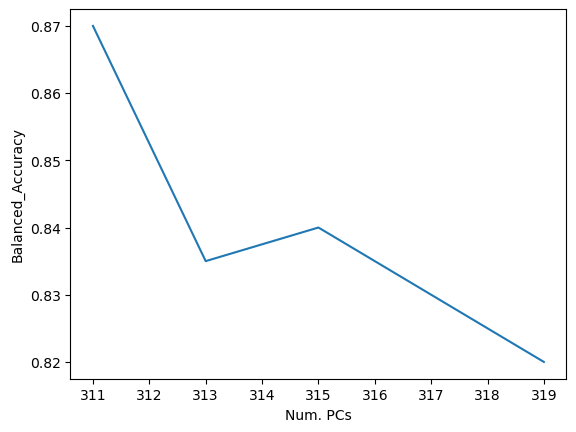

In [53]:
plt.plot(valores,scores_pca)
plt.xlabel("Num. PCs")
plt.ylabel("Balanced_Accuracy")

Me quedo con 311 que me da la misma medida de 'Balance Accuracy' que 319,(de las 320), lo que supone una reducción del 2.5%

In [54]:
rf_pca.fit(X_train_pca[:,:312], y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=4, n_estimators=300)

In [55]:
print(classification_report(y_test, rf_pca.predict(X_test_pca[:,:312])))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.67      1.00      0.80         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       0.67      1.00      0.80         2
          12       1.00      1.00      1.00         2
          13       1.00      0.50      0.67         2
          14       0.67      1.00      0.80         2
          15       1.00      1.00      1.00         2
          16       0.67      1.00      0.80         2
          17       1.00    

c:\Users\Alfonso\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alfonso\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alfonso\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### 4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.

BALANCE_ACCURACY sin pca:  
- RF con cross_validation: 0.68. En classification_report: 0.89
- RF afinando hiperparámetros y entrenado contra train, en classification_report: 0.99
- RF afinando hiperparámetros y entrenado contra test, en classification_report: 0.78

In [56]:
# Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
dic_valores ={'Nº PCAs':311,
              'Scoring en CV':0.88,
              'Scoring vs test':0.94,
              '% Compresion':2.5,
              'Dif. scoring CV base':0.2,
              'Dif. scoring test base':-0.05}


df_resultados = pd.DataFrame(dic_valores,index=['Resultados'])
df_resultados

,Nº PCAs,Scoring en CV,Scoring vs test,% Compresion,Dif. scoring CV base,Dif. scoring test base
Resultados,311,0.88,0.94,2.5,0.2,-0.05


#### 5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

In [57]:
valor_cv = 0.88
valor_test = 0.94
condicion_1 = 0.03 # 3ptos. porcentuales
condicion_2 = 0.05 # 5 ptos. porcentuales

dic_condicion_1 = {}
dic_condicion_2 = {}


for num_pca in range(1,(X_train_pca.shape[1] + 1)):
    print(f'Probando con {num_pca} componentes:')
    X_train_pca_reduced = X_train_pca[:, :num_pca]
    rf_pca.fit(X_train_pca_reduced, y_train)
    score_cross= np.mean(cross_val_score(rf_pca,X_train_pca_reduced,y_train,cv=5,scoring='balanced_accuracy'))

    X_test_pca_reduced = X_test_pca[:, :num_pca]
    score_test = balanced_accuracy_score(y_test, rf_pca.predict(X_test_pca_reduced))
    if valor_cv > score_cross >= (valor_cv*(1-condicion_1)) and valor_test> score_test >= (valor_test*(1-condicion_1)):
        dic_condicion_1[num_pca]=[score_cross,score_test]
        
    elif valor_cv  > score_cross >= (valor_cv*(1-condicion_2)) and valor_test > score_test >= (valor_test*(1-condicion_2)):
        dic_condicion_2[num_pca]=[score_cross,score_test]
        
print("Configuraciones con pérdida inferior a 3 puntos porcentuales:")
if dic_condicion_1:
    print(dic_condicion_1)
else:
    print("No se encontraron configuraciones que cumplan con la condición de pérdida inferior a 3 puntos porcentuales.")

print("Configuraciones con pérdida inferior a 5 puntos porcentuales:")
if dic_condicion_2:
    print(dic_condicion_2)
else:
    print("No se encontraron configuraciones que cumplan con la condición de pérdida inferior a 5 puntos porcentuales.")
        

Probando con 1 componentes:
Probando con 2 componentes:
Probando con 3 componentes:
Probando con 4 componentes:
Probando con 5 componentes:
Probando con 6 componentes:
Probando con 7 componentes:
Probando con 8 componentes:


KeyboardInterrupt: 

Configuraciones con pérdida inferior a 3 puntos porcentuales:  
{100: [0.875, 0.925], 115: [0.8775000000000001, 0.9125], 124: [0.8699999999999999, 0.9375], 146: [0.8775000000000001, 0.925], 159: [0.8674999999999999, 0.925], 170: [0.8700000000000001, 0.925], 172: [0.8574999999999999, 0.925], 173: [0.8775000000000001, 0.9125], 179: [0.8724999999999999, 0.9125], 180: [0.8775000000000001, 0.9125], 191: [0.8775000000000001, 0.9375], 192: [0.8775000000000001, 0.9375], 194: [0.86, 0.9375], 199: [0.875, 0.925], 204: [0.8775000000000001, 0.925], 205: [0.8775000000000001, 0.925], 206: [0.875, 0.9125], 207: [0.8625, 0.925], 212: [0.8574999999999999, 0.925], 224: [0.875, 0.9125], 227: [0.8700000000000001, 0.925], 228: [0.8775000000000001, 0.9125], 235: [0.865, 0.9125], 238: [0.8574999999999999, 0.925], 240: [0.875, 0.9125], 242: [0.8700000000000001, 0.925], 243: [0.8724999999999999, 0.9125], 249: [0.8675, 0.9125], 251: [0.8674999999999999, 0.925], 252: [0.8775000000000001, 0.9125], 256: [0.8550000000000001, 0.9125], 257: [0.8775000000000001, 0.925], 258: [0.86, 0.9375], 261: [0.8775000000000001, 0.9125], 266: [0.8625, 0.9125], 268: [0.8724999999999999, 0.9125], 272: [0.8775000000000001, 0.925], 275: [0.8699999999999999, 0.925], 276: [0.8675, 0.9125], 280: [0.8775000000000001, 0.9125], 283: [0.875, 0.925], 286: [0.86, 0.9375], 287: [0.8724999999999999, 0.9375], 288: [0.8674999999999999, 0.9125], 292: [0.875, 0.9375], 294: [0.8675, 0.9125], 301: [0.8625, 0.925], 303: [0.875, 0.925], 304: [0.8574999999999999, 0.9125], 307: [0.8750000000000002, 0.9125], 311: [0.8550000000000001, 0.9375], 316: [0.86, 0.9125]}

Configuraciones con pérdida inferior a 5 puntos porcentuales:  
{169: [0.845, 0.925], 197: [0.8699999999999999, 0.9], 210: [0.865, 0.9], 214: [0.8799999999999999, 0.9], 226: [0.8700000000000001, 0.9], 236: [0.8525, 0.9125], 245: [0.8674999999999999, 0.9], 247: [0.8750000000000002, 0.9], 250: [0.8524999999999998, 0.9], 253: [0.85, 0.9125], 262: [0.8525, 0.9375], 264: [0.8700000000000001, 0.9], 267: [0.8700000000000001, 0.9], 270: [0.8399999999999999, 0.9], 271: [0.8525, 0.9375], 278: [0.86, 0.9], 281: [0.8700000000000001, 0.9], 282: [0.8625, 0.9], 284: [0.8724999999999999, 0.9], 289: [0.8775000000000001, 0.9], 291: [0.85, 0.9], 293: [0.85, 0.9125], 296: [0.8375, 0.9375], 297: [0.8625, 0.9], 305: [0.8625, 0.9], 306: [0.845, 0.9125], 308: [0.85, 0.9], 309: [0.85, 0.925], 312: [0.8474999999999999, 0.925], 315: [0.8525, 0.9375], 319: [0.8625, 0.9]}

In [58]:
inf_3pp = {100: [0.875, 0.925], 115: [0.8775000000000001, 0.9125], 124: [0.8699999999999999, 0.9375], 146: [0.8775000000000001, 0.925], 159: [0.8674999999999999, 0.925], 170: [0.8700000000000001, 0.925], 172: [0.8574999999999999, 0.925], 173: [0.8775000000000001, 0.9125], 179: [0.8724999999999999, 0.9125], 180: [0.8775000000000001, 0.9125], 191: [0.8775000000000001, 0.9375], 192: [0.8775000000000001, 0.9375], 194: [0.86, 0.9375], 199: [0.875, 0.925], 204: [0.8775000000000001, 0.925], 205: [0.8775000000000001, 0.925], 206: [0.875, 0.9125], 207: [0.8625, 0.925], 212: [0.8574999999999999, 0.925], 224: [0.875, 0.9125], 227: [0.8700000000000001, 0.925], 228: [0.8775000000000001, 0.9125], 235: [0.865, 0.9125], 238: [0.8574999999999999, 0.925], 240: [0.875, 0.9125], 242: [0.8700000000000001, 0.925], 243: [0.8724999999999999, 0.9125], 249: [0.8675, 0.9125], 251: [0.8674999999999999, 0.925], 252: [0.8775000000000001, 0.9125], 256: [0.8550000000000001, 0.9125], 257: [0.8775000000000001, 0.925], 258: [0.86, 0.9375], 261: [0.8775000000000001, 0.9125], 266: [0.8625, 0.9125], 268: [0.8724999999999999, 0.9125], 272: [0.8775000000000001, 0.925], 275: [0.8699999999999999, 0.925], 276: [0.8675, 0.9125], 280: [0.8775000000000001, 0.9125], 283: [0.875, 0.925], 286: [0.86, 0.9375], 287: [0.8724999999999999, 0.9375], 288: [0.8674999999999999, 0.9125], 292: [0.875, 0.9375], 294: [0.8675, 0.9125], 301: [0.8625, 0.925], 303: [0.875, 0.925], 304: [0.8574999999999999, 0.9125], 307: [0.8750000000000002, 0.9125], 311: [0.8550000000000001, 0.9375], 316: [0.86, 0.9125]}
df_inf_3pp = pd.DataFrame(inf_3pp, index=['balance_accuracy','test'])
df_inf_3pp

,100,115,124,146,159,170,172,173,179,180,...,287,288,292,294,301,303,304,307,311,316
balance_accuracy,0.875,0.8775,0.8700,0.8775,0.8675,0.870,0.8575,0.8775,0.8725,0.8775,...,0.8725,0.8675,0.8750,0.8675,0.8625,0.875,0.8575,0.8750,0.8550,0.8600
test,0.925,0.9125,0.9375,0.9250,0.9250,0.925,0.9250,0.9125,0.9125,0.9125,...,0.9375,0.9125,0.9375,0.9125,0.9250,0.925,0.9125,0.9125,0.9375,0.9125


In [59]:
inf_5pp = {169: [0.845, 0.925], 197: [0.8699999999999999, 0.9], 210: [0.865, 0.9], 214: [0.8799999999999999, 0.9], 226: [0.8700000000000001, 0.9], 236: [0.8525, 0.9125], 245: [0.8674999999999999, 0.9], 247: [0.8750000000000002, 0.9], 250: [0.8524999999999998, 0.9], 253: [0.85, 0.9125], 262: [0.8525, 0.9375], 264: [0.8700000000000001, 0.9], 267: [0.8700000000000001, 0.9], 270: [0.8399999999999999, 0.9], 271: [0.8525, 0.9375], 278: [0.86, 0.9], 281: [0.8700000000000001, 0.9], 282: [0.8625, 0.9], 284: [0.8724999999999999, 0.9], 289: [0.8775000000000001, 0.9], 291: [0.85, 0.9], 293: [0.85, 0.9125], 296: [0.8375, 0.9375], 297: [0.8625, 0.9], 305: [0.8625, 0.9], 306: [0.845, 0.9125], 308: [0.85, 0.9], 309: [0.85, 0.925], 312: [0.8474999999999999, 0.925], 315: [0.8525, 0.9375], 319: [0.8625, 0.9]}
df_inf_5pp = pd.DataFrame(inf_5pp, index=['balance_accuracy','test'])
df_inf_3pp


,100,115,124,146,159,170,172,173,179,180,...,287,288,292,294,301,303,304,307,311,316
balance_accuracy,0.875,0.8775,0.8700,0.8775,0.8675,0.870,0.8575,0.8775,0.8725,0.8775,...,0.8725,0.8675,0.8750,0.8675,0.8625,0.875,0.8575,0.8750,0.8550,0.8600
test,0.925,0.9125,0.9375,0.9250,0.9250,0.925,0.9250,0.9125,0.9125,0.9125,...,0.9375,0.9125,0.9375,0.9125,0.9250,0.925,0.9125,0.9125,0.9375,0.9125


In [60]:
best_pca= [0,0,0] #(balanced_accuracy, test, PCA)
for valores in df_inf_3pp:
    temp_1 = df_inf_3pp[valores].iloc[0]
    temp_2 = df_inf_3pp[valores].iloc[1]
    best_1 = best_pca[0]
    best_2 = best_pca[1]
    if temp_1 > best_1 and temp_2 > best_2:
        best_pca[0]=temp_1
        best_pca[1]=temp_2
        best_pca[2]=valores

print(best_pca)

[0.8775000000000001, 0.9375, 191]


La mejor combinación con valores más altos de balance_accuracy y de test sería la de 191 PCAs.  
Sin embargo, la diferencia con 100 PCAs es muy pequeña (-0.002, -0.012) de balance_accuracy y test respectivamente, pero la diferencia de PCAs es de 91 menos (casi un 50% menos). Esto es correcto???

In [ ]:
df_inf_3pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, balance_accuracy to test
Data columns (total 52 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   100     2 non-null      float64
 1   115     2 non-null      float64
 2   124     2 non-null      float64
 3   146     2 non-null      float64
 4   159     2 non-null      float64
 5   170     2 non-null      float64
 6   172     2 non-null      float64
 7   173     2 non-null      float64
 8   179     2 non-null      float64
 9   180     2 non-null      float64
 10  191     2 non-null      float64
 11  192     2 non-null      float64
 12  194     2 non-null      float64
 13  199     2 non-null      float64
 14  204     2 non-null      float64
 15  205     2 non-null      float64
 16  206     2 non-null      float64
 17  207     2 non-null      float64
 18  212     2 non-null      float64
 19  224     2 non-null      float64
 20  227     2 non-null      float64
 21  228     2 non-null      float6

In [ ]:
#best_num_components = None
#best_score_test = float('-inf')  # Inicializamos con el peor valor posible

#for num_pca in range(1, X_train_pca.shape[1] + 1):
    #print(f'Probando con {num_pca} componentes principales:')
    #X_train_pca_reduced = X_train_pca[:, :num_pca]
    #rf_pca.fit(X_train_pca_reduced, y_train)
    #X_test_pca_reduced = X_test_pca[:, :num_pca]
    #score_test = balanced_accuracy_score(y_test, rf_pca.predict(X_test_pca_reduced))
    #print(f'Score en test: {score_test}')
    #if score_test > best_score_test:
        #best_score_test = score_test
        #best_num_components = num_pca

#print(f'Mejor número de componentes principales: {best_num_components}')
#print(f'Score en test con el mejor número de componentes principales: {best_score_test}')

### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

#### 1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.

In [ ]:
# En base a los PCAs hallados anteriormente cuya pérdida tanto en balance_accuracy como en test está por debajo del 3%:
PCA_select = [100,191,227,256,283]

#### 2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.

In [67]:
for pca in PCA_select:
    print(f'Para {pca}:')
    # Instancio con número de PCAs seleccionados
    pca = PCA(pca)
    
    X_train_select = pca.fit_transform(X_train)
    X_train_select_inverse = pca.inverse_transform(X_train_select)

    # Entreno modelo y comparo contra test
    rf_grid.fit(X_train_select, y_train)
    X_test_select = pca.transform(X_test)
    y_predict_select = rf_grid.predict(X_test_select)
    # Hallo el balance_accuracy
    accuracy = balanced_accuracy_score(y_test,y_predict_select)
    print(f'El balance_accuracy es {accuracy:.2f}')

    # Hallo el factor de compresión
    factor_compresion = (1-X_train_select.size/X_train.size)*100
    print(f'El factor de compresión es {factor_compresion:.2f}%')


Para 100:
El balance_accuracy es 0.93
El factor de compresión es 97.56%
Para 191:
El balance_accuracy es 0.94
El factor de compresión es 95.34%
Para 227:
El balance_accuracy es 0.90
El factor de compresión es 94.46%
Para 256:
El balance_accuracy es 0.89
El factor de compresión es 93.75%
Para 283:
El balance_accuracy es 0.90
El factor de compresión es 93.09%


#### 3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 

In [69]:
# Visualización arriba

#### 4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

No sé si estará correcto, pero el valor con 100 PCAs tiene muy buenos números en cuanto a balance_accuracy y al test.

### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)
2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

#### 1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)

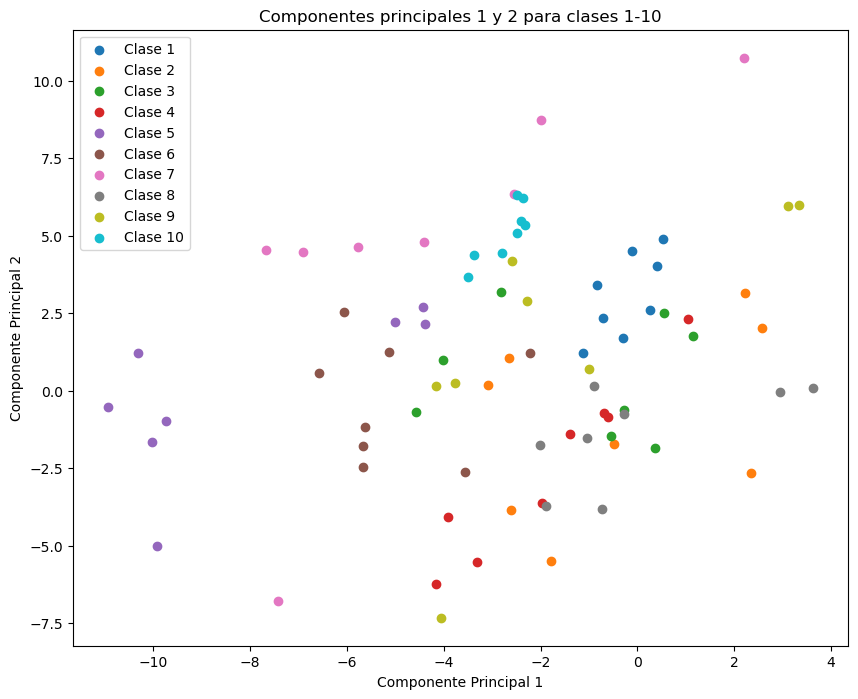

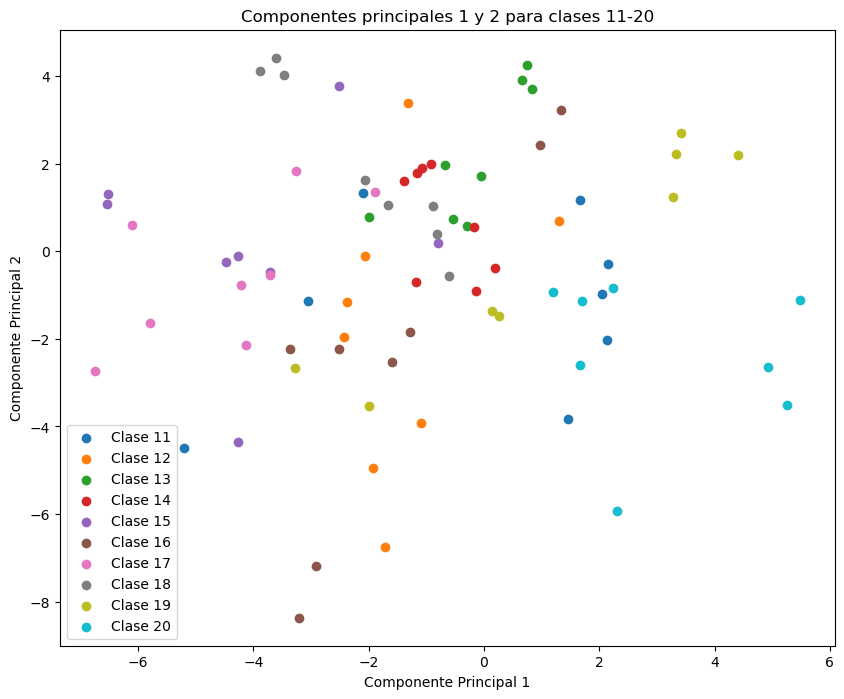

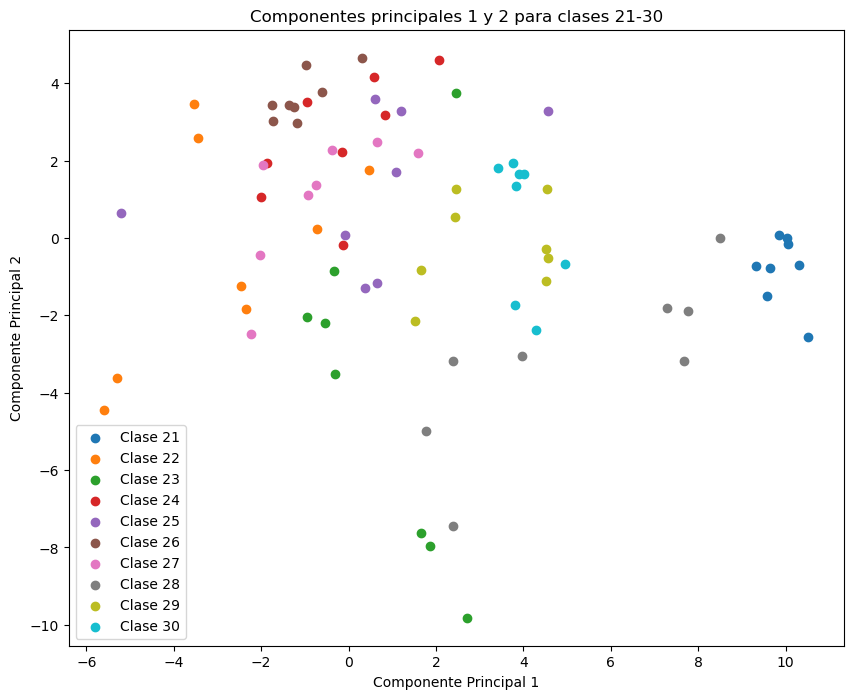

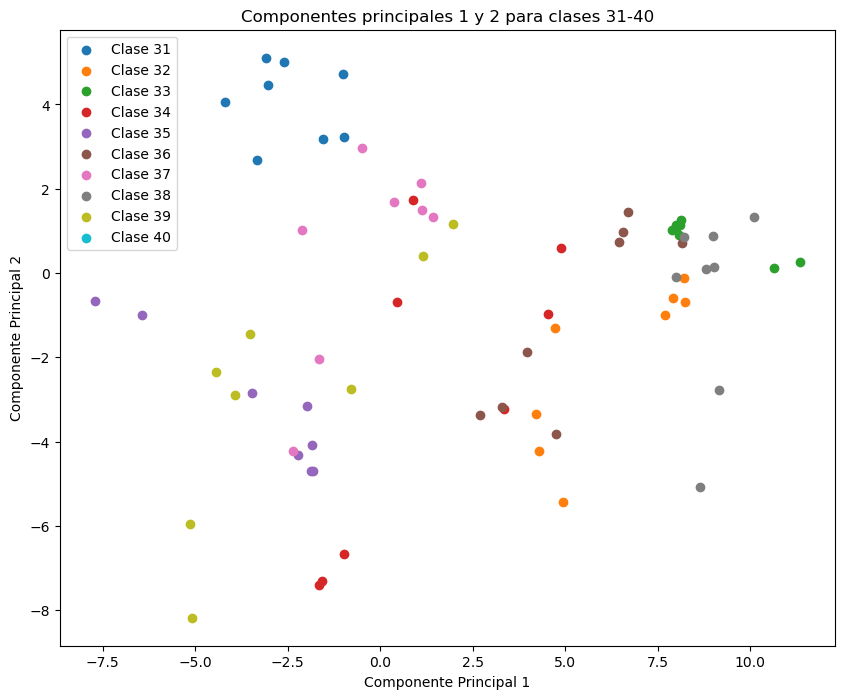

In [73]:
pca = PCA(100)

X_train_select = pca.fit_transform(X_train)
X_train_select_2d = X_train_select[:,:2]

unique_classes = np.unique(y_train)
n_classes = len(unique_classes)
classes_per_plot = 10

# Crear un scatter plot para cada grupo de 10 clases
for i in range(0, n_classes, classes_per_plot):
    plt.figure(figsize=(10, 8))
    start_class = i + 1
    end_class = min(i + classes_per_plot, n_classes)
    for cls in range(start_class, end_class + 1):
        mask = y_train == cls
        plt.scatter(X_train_select_2d[mask, 0], X_train_select_2d[mask, 1], label=f'Clase {cls}')
    
    plt.title(f'Componentes principales 1 y 2 para clases {start_class}-{end_class}')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend()
    plt.show()

Pues me esperaba un poco más de agrupamientos por colores, pero si cambio el número de PCAsa mayores no me cambia mucho la distribución de los colores, siguen siendo muy dispersos.

#### 2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

In [78]:
# Gentileza de chat-GPT
def visualizar_caras(pca_components_list, X_data, n_muestras=5):
    n_filas = len(pca_components_list)
    
    # Asegurarse de que X_data sea un array de NumPy
    if not isinstance(X_data, np.ndarray):
        X_data = X_data.to_numpy()
    
    # Seleccionamos las primeras n_muestras caras para visualización
    muestras_indices = np.random.choice(X_data.shape[0], n_muestras, replace=False)
    X_muestras = X_data[muestras_indices, :]

    plt.figure(figsize=(15, 3 * n_filas))

    for i, n_components in enumerate(pca_components_list):
        # Asegurarse de que n_components no exceda el número de muestras
        n_components = min(n_components, X_muestras.shape[0])
        
        pca = PCA(n_components=n_components)
        X_muestras_comprimidas = pca.fit_transform(X_muestras)
        X_muestras_descomprimidas = pca.inverse_transform(X_muestras_comprimidas)

        for j in range(n_muestras):
            # Original
            plt.subplot(n_filas, n_muestras * 2, i * n_muestras * 2 + 2 * j + 1)
            plt.imshow(X_muestras[j].reshape(64, 64), cmap='gray')
            if j == 0:
                plt.ylabel(f'{n_components} PCs', fontsize=12)
            if i == 0:
                plt.title('Original')
            plt.axis('off')

            # Descomprimida
            plt.subplot(n_filas, n_muestras * 2, i * n_muestras * 2 + 2 * j + 2)
            plt.imshow(X_muestras_descomprimidas[j].reshape(64, 64), cmap='gray')
            if i == 0:
                plt.title('Descomprimida')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

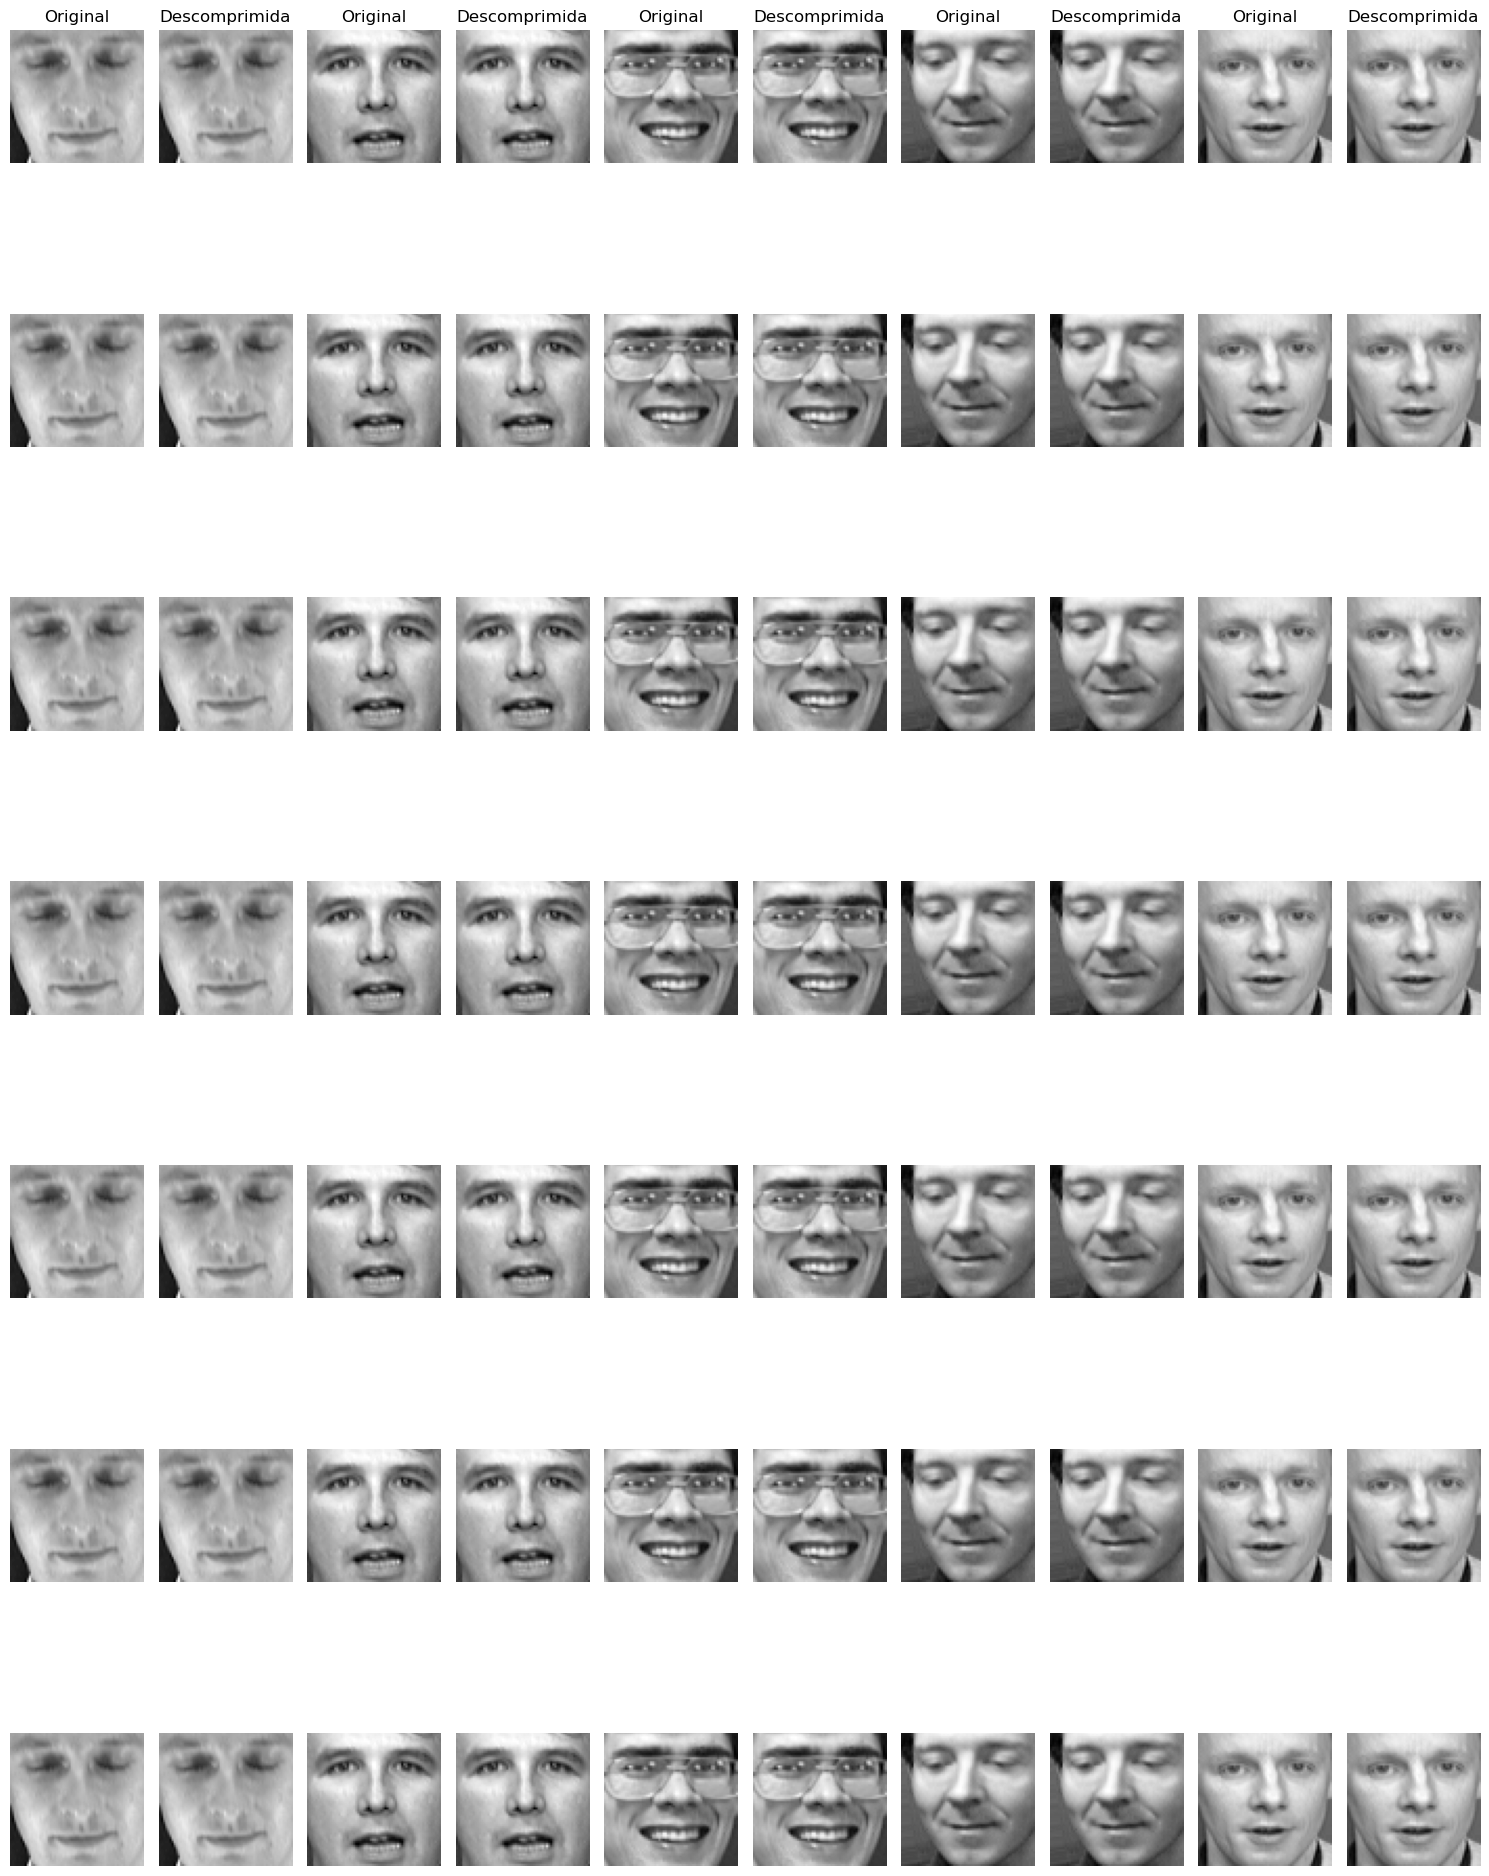

In [79]:
PCA_components_list = [100, 191, 227, 256, 283, 150, 300]

# Llamamos a la función para visualizar las caras
visualizar_caras(PCA_components_list, X_train)

In [80]:
# Como no veía diferencia me ha dado esta otra función, pero se ve incluso mejor que la anterior. Pero el caso es que en principio, es correcta.
def visualizar_caras(pca_components_list, X_data, n_muestras=5):
    n_filas = len(pca_components_list)
    
    # Asegurarse de que X_data sea un array de NumPy
    if not isinstance(X_data, np.ndarray):
        X_data = X_data.to_numpy()
    
    # Seleccionamos las primeras n_muestras caras para visualización
    muestras_indices = np.random.choice(X_data.shape[0], n_muestras, replace=False)
    X_muestras = X_data[muestras_indices, :]

    plt.figure(figsize=(15, 3 * n_filas))

    for i, n_components in enumerate(pca_components_list):
        # Asegurarse de que n_components no exceda el número de muestras
        n_components = min(n_components, X_muestras.shape[0])
        
        pca = PCA(n_components=n_components)
        X_muestras_comprimidas = pca.fit_transform(X_muestras)
        X_muestras_descomprimidas = pca.inverse_transform(X_muestras_comprimidas)

        for j in range(n_muestras):
            # Original
            plt.subplot(n_filas, n_muestras * 2, i * n_muestras * 2 + 2 * j + 1)
            plt.imshow(X_muestras[j].reshape(64, 64), cmap='gray')
            if j == 0:
                plt.ylabel(f'{n_components} PCs', fontsize=12)
            if i == 0:
                plt.title('Original')
            plt.axis('off')

            # Descomprimida
            plt.subplot(n_filas, n_muestras * 2, i * n_muestras * 2 + 2 * j + 2)
            plt.imshow(X_muestras_descomprimidas[j].reshape(64, 64), cmap='gray')
            if i == 0:
                plt.title('Descomprimida')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

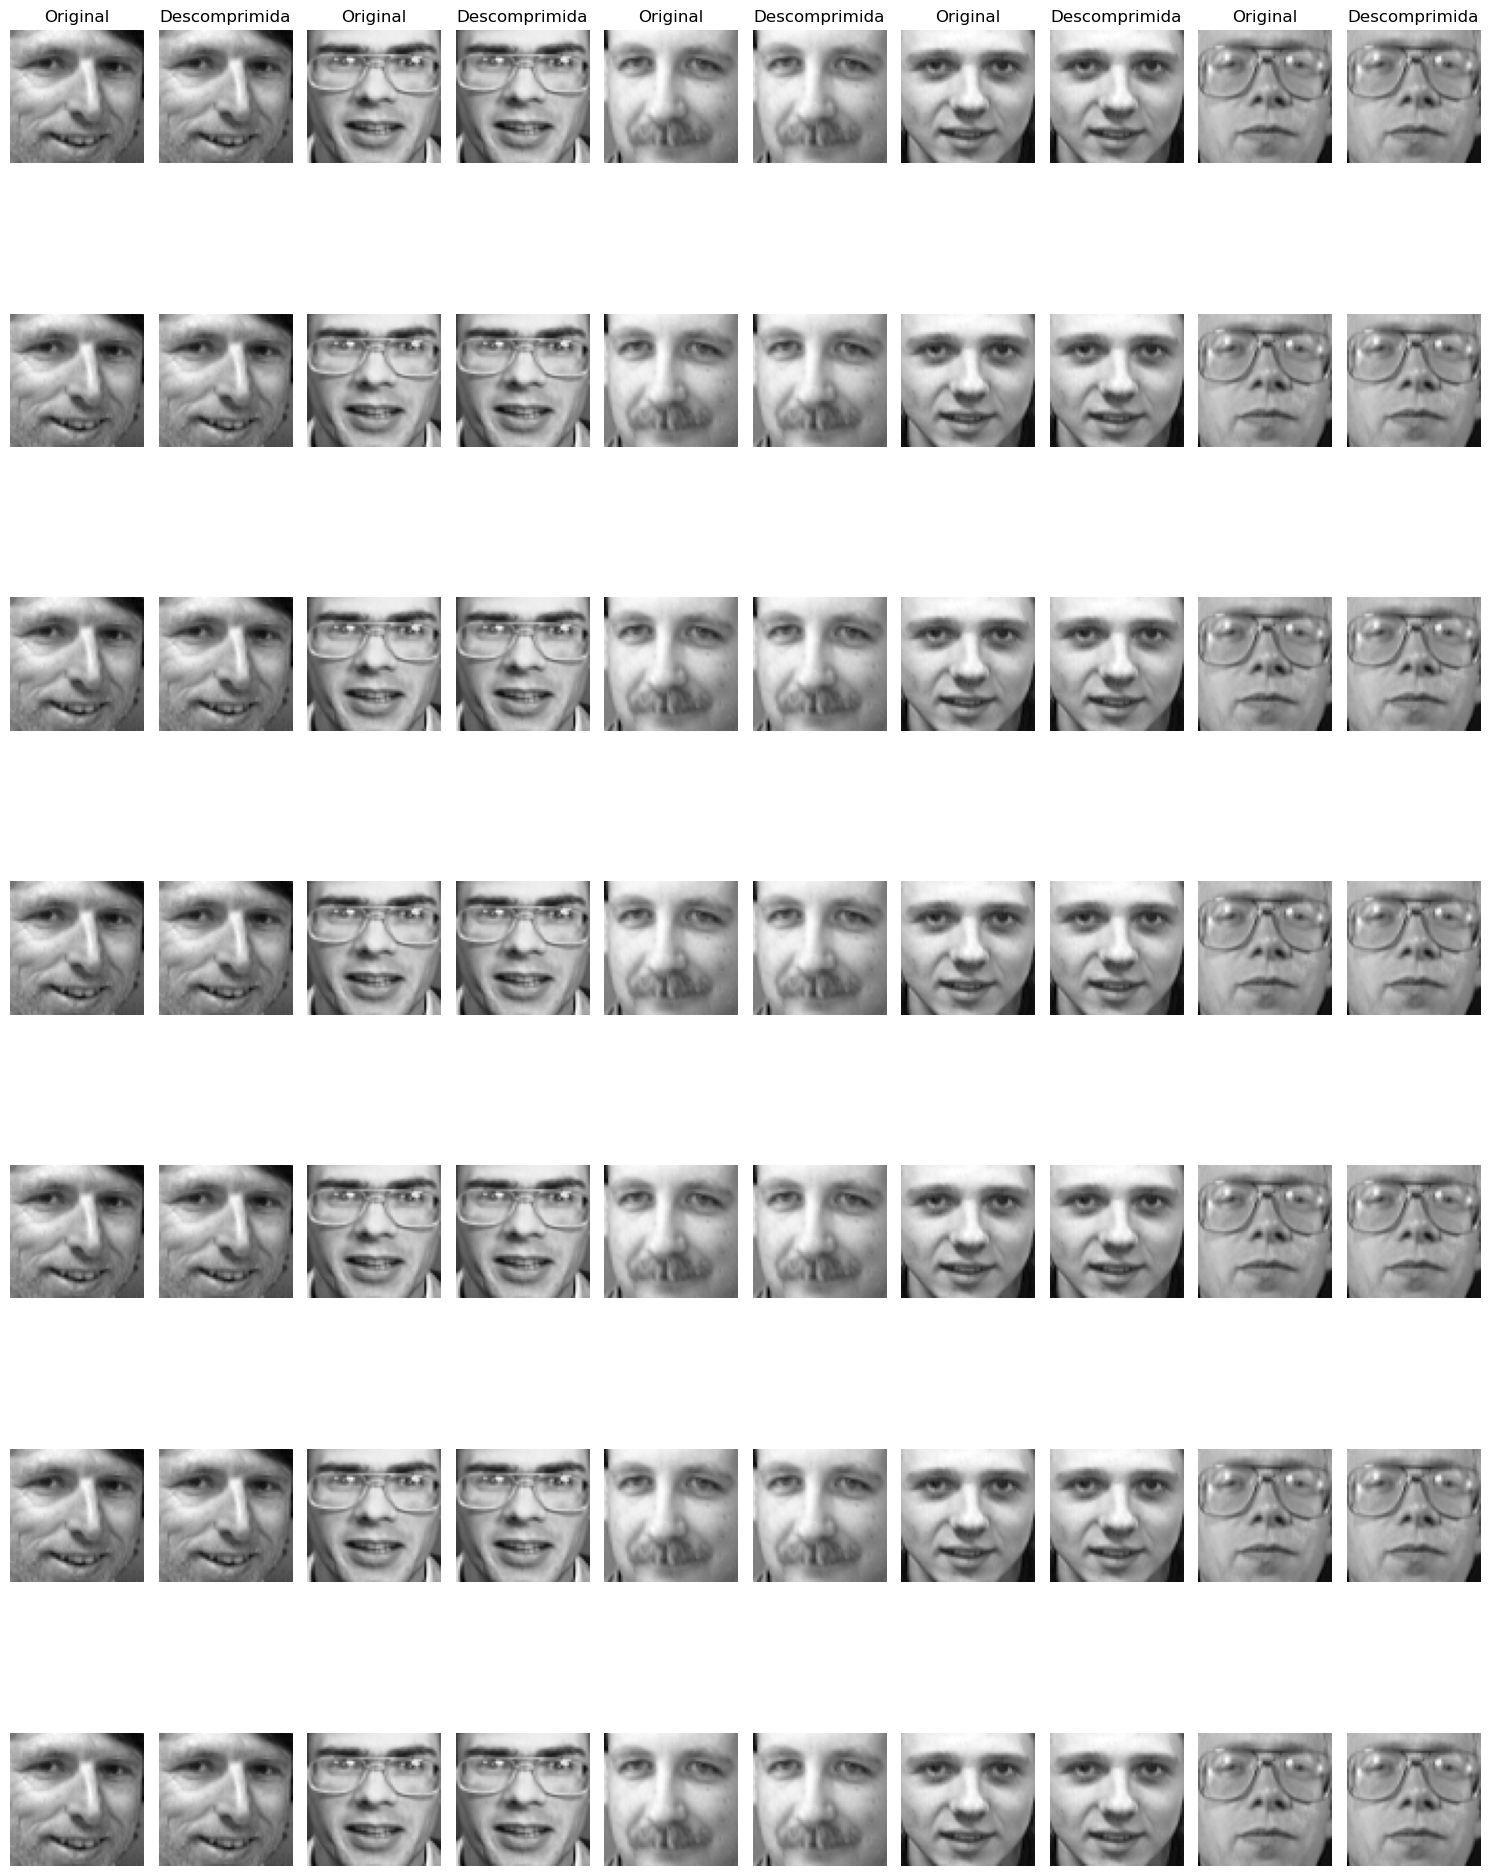

In [81]:
# Definimos la lista de componentes principales a probar
PCA_components_list = [100, 150, 191, 227, 256, 283, 300]

# Llamamos a la función para visualizar las caras
visualizar_caras(PCA_components_list, X_train)